In [ ]:
import argparse
import math
import time

import torch
import torch.nn as nn
import DCM_DeepCausal_CausalConv, utils, Optim, DilatedCausalConv_layer
import numpy as np
#import importlib

import scipy
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import normalized_mutual_info_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

class args:
    data_path = '../../ExperimentData/synthetic0626/A_STD/' 
    graph_path = '../../ExperimentData/synthetic0626/A_STD/'
    
    model = 'DCM_DeepCausal_CausalConv'

    Example = [200, 200, 200, 200]
    SeqLen = [100, 100, 100, 100]
    
    kernel_size = 5
    channel_multiplier = 3

    NumCausalLayer = 4
    NumCluster = 4

    #currently, batchsize and pre_win are fixed to 1 and 1. Do not change it
    batch_size = 8
    pre_win = 1
    pre_win_long = 80
    
    reduce_dim = 50
    low_rank = 30
    
    clip = 1.
    epochs = 10
    dropout = 0.1
    seed = 12345
    gpu = 0

    cuda = False
    optim = 'adam'
    lr = 0.01
    weight_decay = 0

    random_shuffle = True    
    cos_sim_reg_type = 'factor' #options: factor, one_matrix
    cos_lambda = 1.    
    
    copula = True
    normalize = True
    
    graph_learning = 'EF' #'options: USV, EF
    graph_batchnorm = True

np.random.seed(args.seed)
#random.seed(manualSeed)
torch.manual_seed(args.seed)
if args.cuda is True:
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.enabled = False 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

if args.cuda:
    torch.cuda.set_device(args.gpu)
# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    else:
        torch.cuda.manual_seed(args.seed)

GroundTruth_flat = []
GroundTruth = []

Data = utils.Data_utility(args)
args.MaxLen = Data.MaxLen

for i in range(args.NumCluster):
    graph_path = args.graph_path + 'A' + str(i) + '.mat'
    Graph_hat = sio.loadmat(graph_path)['A']
    GroundTruth.append(Graph_hat)
    GroundTruth_flat.append(Graph_hat.reshape(Data.m*Data.m))
    
print('buliding model')
model = eval(args.model).Model(args, Data)

if args.cuda:
    model.cuda()

nParams = sum([p.nelement() for p in model.parameters()])
print('* number of parameters: %d' % nParams)

criterion = nn.MSELoss(size_average=True, reduce=False) #Take the sum, not the average
if args.cuda:
    criterion = criterion.cuda()

optim = Optim.Optim(
    model.parameters(), args.optim, args.lr, args.clip, weight_decay = args.weight_decay,
)

def cos_similarity(a, b):
    return torch.abs(torch.dot(a,b) / (torch.sqrt(torch.dot(a,a)) * torch.sqrt(torch.dot(b,b))))

def find_permutation(n_clusters, real_labels, labels):
    permutation=[]
    for i in range(n_clusters):
        idx = labels == i
        new_label=scipy.stats.mode(real_labels[idx])[0][0]  # Choose the most common label among data points in the cluster
        permutation.append(new_label)
    return permutation
    
def evaluate(loader, data, model, criterion, args):
    total_loss = 0    
    total_loss_reg = 0
    n_samples = 0        
    total_time = 0
    
    pred_labels = []
    new_soft_vectors = []
    true_label_all = []
    
    residuals_alldim_all = [ [] for _ in range(args.NumCluster) ]

    for inputs in loader.get_batches(data, args.batch_size, False):                
        begin_time = time.time()
        
        [sequence, true_label] = inputs #sequence: (variables, timestamps)  
        true_label_all.append(true_label)

        batch_size = 1
        
        X = sequence[:,:-args.pre_win]  #(variables, timestamps)
        Y = sequence[:,-args.pre_win_long:]  #(variables, timestamps)

        Y = Y.transpose(0,1).unsqueeze(0).unsqueeze(2) #(batch_size, pre_win_long, pre_win, m)
                
        Y_hat_list = model(X)
        residuals = torch.zeros((batch_size, args.NumCluster))
               
        for cluster_i in range(args.NumCluster):
            residuals_tmp = criterion(Y_hat_list[cluster_i], Y)
   #         weight_tmp = fea_scaler[cluster_i].repeat(batch_size, args.pre_win, 1)
   #         residuals_tmp = torch.mul(residuals_tmp, weight_tmp)
            residuals[:, cluster_i] = torch.sum(residuals_tmp, dim=(1,2,3))
            residuals_alldim_all[cluster_i].append(residuals_tmp.detach().numpy())

        new_soft_vectors.append(residuals)
        
        loss_reg = torch.sum(torch.min(residuals, dim=1)[0]) / (args.pre_win * batch_size * Data.m * args.pre_win_long)
        pred_labels.append(torch.min(residuals, dim=1)[1])
        
        batch_loss = loss_reg        
                                            
        total_loss += batch_loss.data.item()
        total_loss_reg += loss_reg.data.item()    
        total_time = total_time + time.time() - begin_time  
        
        n_samples += batch_size

    total_loss /= (n_samples)
    total_loss_reg /= (n_samples)
        
    true_labels = np.stack(true_label_all)
    pred_labels = (torch.cat(pred_labels, dim = 0)).detach().numpy()

    new_soft_vectors = (torch.cat(new_soft_vectors, dim = 0)).detach().numpy()
    new_soft_vectors = preprocessing.scale(new_soft_vectors)
    
    for clust_i in range(args.NumCluster):
        residuals_alldim_all[clust_i] = np.concatenate(residuals_alldim_all[clust_i], axis = 0)
        
    return total_time, total_loss, total_loss_reg, n_samples, pred_labels, true_labels, new_soft_vectors


def train(loader, data, model, criterion, optim, args):
    model.train()

    total_loss = 0    
    total_loss_reg = 0
    total_loss_cos = 0
    n_samples = 0        
    total_time = 0
    
    count = 0
    
    pred_labels = []
    new_soft_vectors = []
    true_label_all = []    

    residuals_alldim_all = [ [] for _ in range(args.NumCluster) ]

    for inputs in loader.get_batches(data, args.batch_size, True):                
        begin_time = time.time()
        
        [sequence, true_label] = inputs #sequence: #(batch_size, variables, timestamps)
        true_label_all.append(true_label)
        
        model.zero_grad()

        X = sequence[:,:,:-args.pre_win]  #(batch_size, variables, timestamps)
        Y = sequence[:,:,-args.pre_win_long:] #(batch_size, variables, timestamps)
        batch_size = len(X)
        
        Y = Y.transpose(1,2).unsqueeze(2) #(batch_size, pre_win_long, pre_win, m)
        
        Y_hat_list = model(X) 
        residuals = torch.zeros((batch_size, args.NumCluster))

        for cluster_i in range(args.NumCluster):
            residuals_tmp = criterion(Y_hat_list[cluster_i], Y)            
            residuals[:, cluster_i] = torch.sum(residuals_tmp, dim=(1,2,3))
            residuals_alldim_all[cluster_i].append(residuals_tmp.detach().numpy())

        new_soft_vectors.append(residuals)
        loss_reg = torch.sum(torch.min(residuals, dim=1)[0]) / (args.pre_win * batch_size * Data.m * args.pre_win_long) 
        pred_labels.append(torch.min(residuals, dim=1)[1])
        
        Cos_loss = torch.tensor(0.0)
        graph_tensor_list = []
        
        if args.cos_sim_reg_type == 'factor':
            for i_i in range(args.NumCluster):
                graph_tensor_list_clst = []
                
                if args.graph_learning == 'USV':
                    graph_tensor_list_clst.append(model.graph_net[i_i].single_graph_net[0].weight.flatten())
                    graph_tensor_list_clst.append(model.graph_net[i_i].single_graph_net[1].weight.flatten())
                    graph_tensor_list_clst.append(model.graph_net[i_i].single_graph_net[2].weight.flatten())
                elif args.graph_learning == 'EF':
                    graph_tensor_list_clst.append(model.graph_net[i_i].single_graph_net[0].weight.flatten())
                    graph_tensor_list_clst.append(model.graph_net[i_i].single_graph_net[1].weight.flatten())                    
                
                graph_tensor_clst = torch.cat(graph_tensor_list_clst)
                graph_tensor_list.append(graph_tensor_clst)

        elif args.cos_sim_reg_type == 'one_matrix':
            graph_tensor_list = []
            graph_list = model.predict_relationship_inside()               
            for clust_i in range(args.NumCluster):
                graph_tensor_list.append(graph_list[clust_i].flatten())
                
        if len(graph_tensor_list) > 0:
            for i_i in range(args.NumCluster - 1):
                for j_i in range(i_i+1, args.NumCluster):
                    Cos_loss += cos_similarity(graph_tensor_list[i_i], graph_tensor_list[j_i])           

        batch_loss = loss_reg + args.cos_lambda*Cos_loss        
        
   #     torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
                                    
        batch_loss.backward(retain_graph = True)
        total_loss += batch_loss.data.item()
        total_loss_reg += loss_reg.data.item()    
        total_loss_cos += Cos_loss.data.item()    

        total_time = total_time + time.time() - begin_time  
        
        optim.step()
        n_samples += batch_size
        count += 1

    total_loss /= (n_samples)
    total_loss_reg /= (n_samples)
    total_loss_cos /= count

    true_labels = np.concatenate(true_label_all, axis = 0)
 #   true_labels = np.stack(true_label_all)
    pred_labels = (torch.cat(pred_labels, dim = 0)).detach().numpy()

    for clust_i in range(args.NumCluster):
        residuals_alldim_all[clust_i] = np.concatenate(residuals_alldim_all[clust_i], axis = 0)

    new_soft_vectors = (torch.cat(new_soft_vectors, dim = 0)).detach().numpy()
    new_soft_vectors_norm = preprocessing.scale(new_soft_vectors)
    return total_time, total_loss, total_loss_reg, total_loss_cos, n_samples, pred_labels, true_labels, new_soft_vectors_norm, residuals_alldim_all

print("begin training")
total_loss_set1 = []
total_loss_reg_set1 = []
total_loss_cos_set1 = []
total_loss_set2 = []
total_loss_reg_set2 = []

residuals_set1 = []

for epoch in range(0, args.epochs):
    epoch_time, total_loss1, total_loss_reg1, total_loss_cos1, n_samples1, pred_labels1, true_labels1, residuals1, residuals_alldim1 = train(Data, Data.train, model, criterion, optim, args)
 #   _, total_loss2, total_loss_reg2, n_samples2, pred_labels2, true_labels2, residuals2 = evaluate(Data, Data.valid, model, criterion, args)
    
    total_loss_set1.append(total_loss1)
    total_loss_reg_set1.append(total_loss_reg1)
    total_loss_cos_set1.append(total_loss_cos1)
    # total_loss_set2.append(total_loss2)
    # total_loss_reg_set2.append(total_loss_reg2)

    residuals_set1.append(residuals1)

    CGraph_list = model.predict_relationship_inside()
    AUPR_list = []
    AUROC_list = []

    if epoch == 0:
        print('Training Samples per cluster {:3d}'.format(n_samples1 // args.NumCluster))

    min_res_NMI1 = normalized_mutual_info_score(true_labels1, pred_labels1)
#    min_res_NMI2 = normalized_mutual_info_score(true_labels2, pred_labels2)

    print('Epoch {:3d}|time:{:5.2f}s|total_loss_train:{:5.4f}|regression_loss_train:{:5.4f}|cos_reg_loss_train:{:5.4f}|'.format(epoch, epoch_time, total_loss1, total_loss_reg1, total_loss_cos1))
#    print('$total_loss_test:{:5.4f}|regression_loss_test:{:5.4f}|'.format(total_loss2, total_loss_reg2))

    print('$MinRes NMI for training {:5.4f}'.format(min_res_NMI1))
    
    if epoch % 5 == 0:   
        
        GMM_model1 = GaussianMixture(n_components=args.NumCluster, reg_covar=1e-11)
        GMM_model1.fit(residuals1) 
        GMM_labels1 = GMM_model1.predict(residuals1)        
    
        KM_model1 = KMeans(n_clusters=args.NumCluster, n_init=30, random_state=np.random.randint(0, 500), tol = 1e-5)
        KM_labels1 = KM_model1.fit(residuals1).labels_

        # GMM_model2 = GaussianMixture(n_components=args.NumCluster, reg_covar=1e-11)
        # GMM_model2.fit(residuals2) 
        # GMM_labels2 = GMM_model2.predict(residuals2)        
    
        # KM_model2 = KMeans(n_clusters=args.NumCluster, n_init=30, random_state=np.random.randint(0, 500), tol = 1e-5)
        # KM_labels2 = KM_model2.fit(residuals2).labels_
        
        KM_NMI1 = normalized_mutual_info_score(true_labels1, KM_labels1)
        GMM_NMI1 = normalized_mutual_info_score(true_labels1, GMM_labels1)
    
        # KM_NMI2 = normalized_mutual_info_score(true_labels2, KM_labels2)
        # GMM_NMI2 = normalized_mutual_info_score(true_labels2, GMM_labels2)

        print('|Kmeans_NMI_trn:{:5.3f}|GMM_NMI_trn:{:5.3f}'.format(KM_NMI1, GMM_NMI1))
 #       print('|Kmeans_NMI_tst:{:5.3f}|GMM_NMI_tst:{:5.3f}'.format(KM_NMI2, GMM_NMI2))

    if epoch > 500:
        permutation1 = find_permutation(args.NumCluster, true_labels1, pred_labels1)
 #       permutation2 = find_permutation(args.NumCluster, true_labels2, pred_labels2)
    else:
        permutation1 = np.array(range(args.NumCluster))
#        permutation2 = np.array(range(args.NumCluster))

    new_labels1 = [ permutation1[label] for label in pred_labels1]   # permute the labels 
    min_res_ACC1 = accuracy_score(true_labels1, new_labels1)

    # new_labels2 = [ permutation2[label] for label in pred_labels2]   # permute the labels 
    # min_res_ACC2 = accuracy_score(true_labels2, new_labels2)
       
    for cluster_i in range(len(CGraph_list)):
        CGraph = CGraph_list[cluster_i].reshape(model.m*model.m).detach().numpy()

        precision, recall, _ = metrics.precision_recall_curve(GroundTruth_flat[permutation1[cluster_i]], CGraph)
        aupr = metrics.auc(recall, precision)

        fpr, tpr, _ = metrics.roc_curve(GroundTruth_flat[permutation1[cluster_i]], CGraph)
        auroc = metrics.auc(fpr, tpr)
    
        AUPR_list.append(aupr)
        AUROC_list.append(auroc)
        print('Class{:3d}|AUPR{:5.2f}|AUROC{:5.2f}'.format(cluster_i, aupr, auroc))
    
    print("#"*20)
        
for cluster_i in range(len(CGraph_list)):
    plt.figure(cluster_i)
    plt.subplot(121)
    plt.imshow(GroundTruth[permutation1[cluster_i]])
    plt.subplot(122)
    CGraph = CGraph_list[cluster_i].detach().numpy()    
    plt.imshow(CGraph)  

buliding model
* number of parameters: 65980
begin training
Training Samples per cluster 200
Epoch   0|time:258.69s|total_loss_train:0.1369|regression_loss_train:0.1250|cos_reg_loss_train:0.0953|
$MinRes NMI for training 0.0152
|Kmeans_NMI_trn:0.003|GMM_NMI_trn:0.007
Class  0|AUPR 0.01|AUROC 0.56
Class  1|AUPR 0.01|AUROC 0.46
Class  2|AUPR 0.01|AUROC 0.49
Class  3|AUPR 0.01|AUROC 0.50
####################
Epoch   1|time:249.11s|total_loss_train:0.1317|regression_loss_train:0.1247|cos_reg_loss_train:0.0562|
$MinRes NMI for training 0.3492
Class  0|AUPR 0.01|AUROC 0.57
Class  1|AUPR 0.01|AUROC 0.46
Class  2|AUPR 0.01|AUROC 0.49
Class  3|AUPR 0.01|AUROC 0.47
####################
Epoch   2|time:271.55s|total_loss_train:0.1293|regression_loss_train:0.1236|cos_reg_loss_train:0.0450|
$MinRes NMI for training 0.5750
Class  0|AUPR 0.01|AUROC 0.58
Class  1|AUPR 0.01|AUROC 0.51
Class  2|AUPR 0.01|AUROC 0.51
Class  3|AUPR 0.01|AUROC 0.44
####################
Epoch   3|time:265.74s|total_loss_train

In [12]:
CGraph_list = model.predict_relationship_inside()

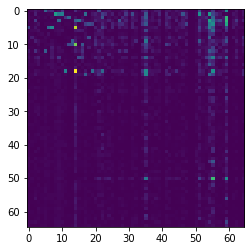

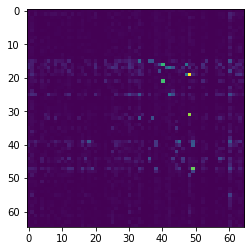

In [13]:
plt.figure(1)
plt.imshow(CGraph_list[0].detach().numpy().reshape((Data.m, Data.m)))
plt.figure(2)
plt.imshow(CGraph_list[1].detach().numpy().reshape((Data.m, Data.m)))

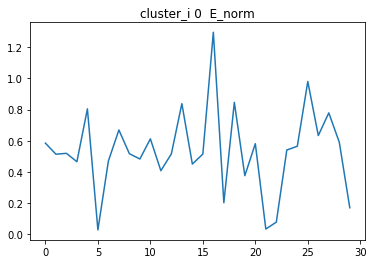

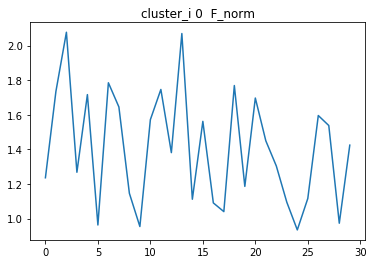

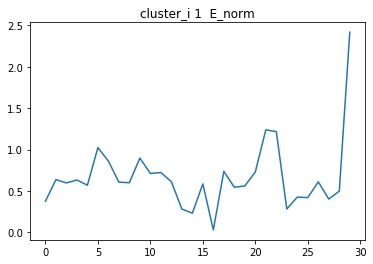

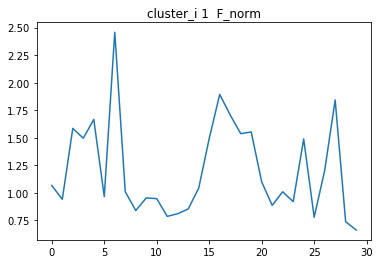

In [14]:
import numpy.linalg as LA
for cluster_i in range(args.NumCluster):
    E = model.graph_net[cluster_i].single_graph_net[0].weight.detach().numpy()
    F = model.graph_net[cluster_i].single_graph_net[1].weight.detach().numpy().transpose(1,0)
    E_norm = LA.norm(E, axis = 1)
    F_norm = LA.norm(F, axis = 1)
    plt.figure(2*cluster_i)
    plt.plot(E_norm)
    plt.title('cluster_i ' + str(cluster_i) + '  E_norm')
    
    plt.figure(2*cluster_i+1)
    plt.plot(F_norm)
    plt.title('cluster_i ' + str(cluster_i) + '  F_norm')
    